In [1]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u
from models import morales2009, pentzer2014pow, pentzer2022
from steps import preprocess
from utils import gps_processing as gpsp
from utils import odom_utils as odou
from visualization import papermode

papermode(plt, size=18)

In [2]:
# Parameters
abbr = "R08"

In [3]:
preprocess(abbr, verbose=False)
m2009df = morales2009.morales2009(abbr, verbose=False)
p2014df = pentzer2014pow.pentzer2014pow(abbr, verbose=False)
p2022df = pentzer2022.pentzer2022(abbr, verbose=False)

R08: 100%|██████████| 1553/1553 [00:00<00:00, 6266.90it/s]


In [4]:
basename = u.get_basename(u.get_filename(abbr))
figdir = u.get_figdir(basename, subdir=f"maps")
rundir = u.get_rundir(basename)
gps_df = pd.read_csv(rundir / f"{abbr}-DEMelevation.csv")
gps_df["dist"] = gpsp.compute_traveled_distance(lat=gps_df.Y, lon=gps_df.X)
gps_df["travel_dist"] = gps_df.dist.cumsum()

/home/norlab/code/202206/terrain-code/utils/gps_processing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geodf.pts_next.loc[geodf.pts_next.isna()] = None


In [5]:
if not "long" in p2022df.columns.values:
    coords = odou.transform_odom(p2022df.px, p2022df.py, abbr=abbr)
else:
    coords = p2022df[["long", "lat"]].copy().rename(columns={"long": "lon"})

In [6]:
terrain_change = 220
all_dfs = (m2009df, p2014df, p2022df)
for df in all_dfs:
    df.rename(columns={"long":"lon"},inplace=True)
    df["terrain"] = "snow"
    df["terrain"] = df.terrain.mask(df.index < terrain_change, "sandy loam")

In [7]:
terrains = ["sandy loam", "snow"]
terr_cols = {terr: u.COLORS[terr] for terr in terrains}

In [8]:
gps_df.shape, m2009df.shape

((1553, 5), (1553, 104))

# $\mu$ vs elevation


Text(0.5, 0, '$\\mu$')

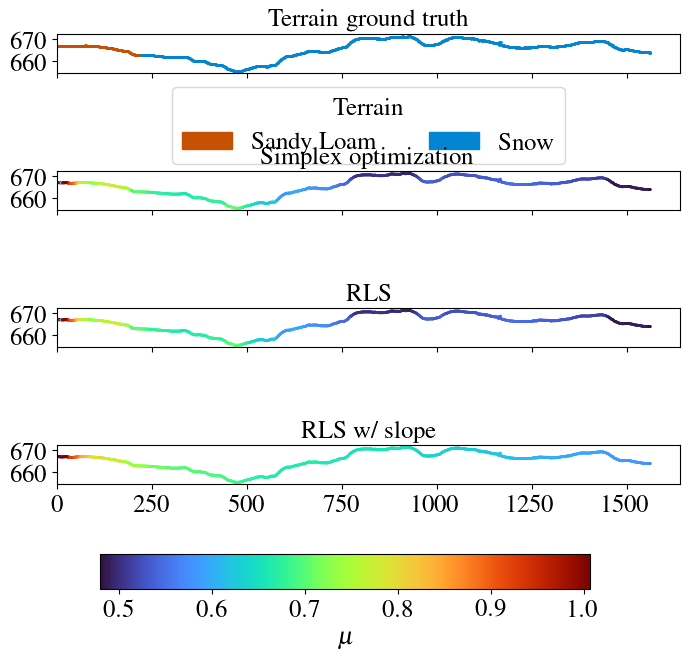

In [13]:
fig, subfigs = plt.subplots(nrows=4, sharex=True, figsize=(7,7))

cseries = pd.concat([df.m_sym.iloc[30:] for df in all_dfs], ignore_index=True)
cm = plt.get_cmap("turbo")
cnorm = mpl.colors.Normalize(
    vmin=cseries.iloc[:].min(),
    vmax=cseries.iloc[:].max(),
)
scmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cm)

[ax0, ax1, ax2, ax3] = subfigs

for terr in m2009df.terrain.unique():
    terridx = m2009df.terrain == terr
    ax0.scatter(m2009df.time_rel[terridx], gps_df.Z[terridx], c=terr_cols[terr], s=1, label=terr.title())

sc1 = ax1.scatter(m2009df.time_rel, gps_df.Z, c=scmap.to_rgba(m2009df.m_sym), s=1)
sc2 = ax2.scatter(p2014df.time_rel, gps_df.Z, c=scmap.to_rgba(p2014df.m_sym), s=1)
sc3 = ax3.scatter(p2022df.time_rel, gps_df.Z, c=scmap.to_rgba(p2022df.m_sym), s=1)

terrain_handles = [mpatches.Patch(color=col, label=lab.title()) for lab, col in terr_cols.items()]
ax0.legend(
    handles=terrain_handles,
    ncols=2,
    bbox_to_anchor=(0.5, -0.03),
    loc="upper center",
    title="Terrain",
)

ax0.set_title("Terrain ground truth")
ax1.set_title("Simplex optimization")
ax2.set_title("RLS")
ax3.set_title("RLS w/ slope")

ax1.set_xlim(left=0)

fig.tight_layout()

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(scmap, orientation="horizontal", cax=cbar_ax)
cbar_ax.set_xlabel("$\mu$")
# cb = fig.colorbar(scmap, orientation="horizontal", pad=0.1, ax=ax)

# for ext in u.EXTS:
#     fig.savefig(figdir / f"{abbr}_msym_map.{ext}", bbox_inches="tight")

# DONE
